In [52]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [53]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [54]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [55]:
%matplotlib inline

In [56]:
%store -r X_relative_footsteps_continuous
%store -r Y_relative_footsteps_continuous
print(X_relative_footsteps_continuous.shape)
print(Y_relative_footsteps_continuous.shape)

(21421, 28)
(21421, 8)


# Multivariate Linear Regression (Foot prediction)

In [57]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [58]:
X_relative_footsteps_continuous[0, :]

array([ 1.00000000e-01,  0.00000000e+00,  0.00000000e+00,  2.84895771e-02,
       -2.91453020e-02,  2.23710749e-02, -8.38189804e-04,  2.31294258e-02,
        9.54991797e-03,  2.23055032e-01,  1.73126695e-01, -4.09548272e-01,
        2.39919112e-01, -1.66095484e-01, -4.09774008e-01, -2.37248781e-01,
        1.66372462e-01, -4.12611949e-01, -2.53876758e-01, -1.60041555e-01,
       -4.13015290e-01,  0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  1.00000000e-01,  0.00000000e+00,  0.00000000e+00])

In [59]:
# Entries where FL is swinging
idxs = np.where(X_relative_footsteps_continuous[:, 21] == 1)[0]
X_relative_footsteps_continuous_FL_swinging = X_relative_footsteps_continuous[idxs]
Y_relative_footsteps_continuous_FL_swinging = Y_relative_footsteps_continuous[idxs]

## Predict FL foot -> x

In [60]:
X_relative_footsteps_continuous_FL_swinging.shape

(10728, 28)

In [61]:
X_relative_footsteps_continuous_FL_swinging[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.01715523,  0.02680482,
        0.05156133, -0.00914702,  0.0315145 , -0.02258525,  0.23698767,
        0.17026876, -0.40873471,  0.23344301, -0.16811552, -0.40935065,
       -0.24342878,  0.16518854, -0.41243429, -0.24083982, -0.16411242,
       -0.41243872,  1.        ,  0.        ,  0.        ,  1.        ,
        0.1       ,  0.        ,  0.        ])

In [62]:
Y_relative_footsteps_continuous_FL_swinging[0, :]

array([ 0.22567786,  0.17359778,  0.23985769, -0.16623835, -0.23764378,
        0.16585226, -0.25201704, -0.15896871])

### Linear Regression

In [105]:
# Input
X = np.hstack((X_relative_footsteps_continuous_FL_swinging[:, :3], # motion command
               X_relative_footsteps_continuous_FL_swinging[:, 9:11], # FL (x,y) position
               X_relative_footsteps_continuous_FL_swinging[:, 12:14], # FR (x,y) position
               X_relative_footsteps_continuous_FL_swinging[:, 15:17], # RL (x,y) position
               X_relative_footsteps_continuous_FL_swinging[:, 18:20])) # RR (x,y) position 

# Target
Y = np.array([Y_relative_footsteps_continuous_FL_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_fl_relative_support_x = LinearRegression()

# Fit the model
model_fl_relative_support_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_relative_support_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9967467492420999
RMSE:  0.0016487368744050462
The lowest error is:  1.0622850338259937e-07
The highest error is:  0.018141171085316654
The avg. error is:  0.0010189770077142894


In [106]:
model_fl_relative_support_x.coef_

array([[-0.17641215,  0.03131934,  0.07871106,  1.05227865, -0.08513168,
        -0.20973094, -0.01233789, -0.25000596,  0.11463451,  0.00961209,
        -0.2744822 ]])

In [107]:
model_fl_relative_support_x.intercept_

array([-0.06709406])

Text(0, 0.5, 'Predictions')

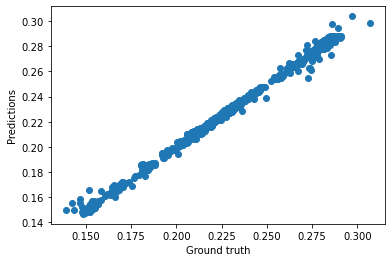

In [108]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [24]:
#%store model_fl_relative_support_x

In [25]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [26]:
# Save model
#joblib.dump(model_fl_relative_support_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fl_relative_support_x.sav")

### Predict FL foot -> y

In [163]:
# Input
X = np.hstack((X_relative_footsteps_continuous_FL_swinging[:, :3], # motion command
               X_relative_footsteps_continuous_FL_swinging[:, 9:11], # FL (x,y) position
               X_relative_footsteps_continuous_FL_swinging[:, 12:14], # FR (x,y) position
               X_relative_footsteps_continuous_FL_swinging[:, 15:17], # RL (x,y) position
               X_relative_footsteps_continuous_FL_swinging[:, 18:20])) # RR (x,y) position 

# Target
Y = np.array([Y_relative_footsteps_continuous_FL_swinging[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_fl_relative_support_y = LinearRegression()

# Fit the model
model_fl_relative_support_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_relative_support_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9976441645829224
RMSE:  0.0019500609991911118
The lowest error is:  8.419610898202645e-07
The highest error is:  0.02632471103398354
The avg. error is:  0.0011362219815500936


In [164]:
model_fl_relative_support_y.coef_

array([[ 0.03503179, -0.14626197, -0.21638538,  0.04550731,  0.88492912,
         0.13741106, -0.38422713,  0.1142604 , -0.37038488, -0.29456627,
        -0.35413788]])

In [165]:
model_fl_relative_support_y.intercept_

array([-0.12705611])

Text(0, 0.5, 'Predictions')

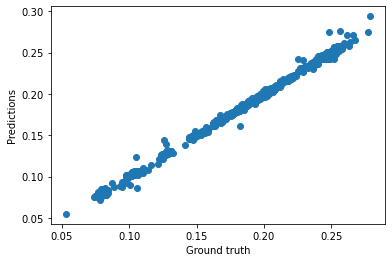

In [166]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [31]:
#%store model_fl_relative_support_y

In [32]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [25]:
# Save model
#joblib.dump(model_fl_relative_support_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fl_relative_support_y.sav")